## Electronic Product Sales Analysis

In [1]:
import findspark
findspark.init()

In [2]:
import os
import copy
import pyspark

import pyspark.sql.types as ptypes
import pyspark.sql.functions as funcs
from pyspark.sql.functions import (count, col, when, isnan, to_timestamp, from_unixtime, unix_timestamp, 
                                   month, to_date, date_format, split)

In [3]:
ss = pyspark.sql.SparkSession.builder.master('local[*]').appName('Sales').getOrCreate()

In [4]:
ss

In [29]:
%matplotlib inline

In [30]:
%config InlineBackend.rc = {'figure.figsize': (16, 6)}

In [14]:
current_dir_path = os.path.abspath(os.path.curdir)
sales_path = f'{current_dir_path}/data/source/ProductSales/*.csv'
sales_data = ss.read.csv(sales_path, inferSchema=True, header=True)

In [15]:
sales_data.schema

StructType(List(StructField(Order ID,IntegerType,true),StructField(Product,StringType,true),StructField(Quantity Ordered,IntegerType,true),StructField(Price Each,DoubleType,true),StructField(Order Date,StringType,true),StructField(Purchase Address,StringType,true)))

In [16]:
sales_data.count()

186850

In [17]:
sales_data.printSchema()

root
 |-- Order ID: integer (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity Ordered: integer (nullable = true)
 |-- Price Each: double (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Purchase Address: string (nullable = true)



In [18]:
sales_data.describe().show()

+-------+------------------+------------+------------------+------------------+--------------+--------------------+
|summary|          Order ID|     Product|  Quantity Ordered|        Price Each|    Order Date|    Purchase Address|
+-------+------------------+------------+------------------+------------------+--------------+--------------------+
|  count|            185950|      186305|            185950|            185950|        186305|              186305|
|   mean| 230417.5693788653|        null|1.1243828986286637|184.39973476747707|          null|                null|
| stddev|51512.737109995265|        null|0.4427926240286704| 332.7313298843439|          null|                null|
|    min|            141234|20in Monitor|                 1|              2.99|01/01/19 03:07|1 11th St, Atlant...|
|    max|            319670|      iPhone|                 9|            1700.0|    Order Date|    Purchase Address|
+-------+------------------+------------+------------------+------------

In [19]:
sales_data.select([count(when(isnan(colmn) | col(colmn).isNull(), colmn)).alias(colmn) for colmn in sales_data.columns]).show()

+--------+-------+----------------+----------+----------+----------------+
|Order ID|Product|Quantity Ordered|Price Each|Order Date|Purchase Address|
+--------+-------+----------------+----------+----------+----------------+
|     900|    545|             900|       900|       545|             545|
+--------+-------+----------------+----------+----------+----------------+



In [20]:
sales_data_dropna = sales_data.dropna()

In [21]:
sales_data_dropna.select([count(when(isnan(colmn) | col(colmn).isNull(), colmn)).alias(colmn) for colmn in sales_data_dropna.columns]).show()

+--------+-------+----------------+----------+----------+----------------+
|Order ID|Product|Quantity Ordered|Price Each|Order Date|Purchase Address|
+--------+-------+----------------+----------+----------+----------------+
|       0|      0|               0|         0|         0|               0|
+--------+-------+----------------+----------+----------+----------------+



In [22]:
sales_data_dropna.count()

185950

In [23]:
sales_data_dropna.describe().show()

+-------+------------------+------------+------------------+------------------+--------------+--------------------+
|summary|          Order ID|     Product|  Quantity Ordered|        Price Each|    Order Date|    Purchase Address|
+-------+------------------+------------+------------------+------------------+--------------+--------------------+
|  count|            185950|      185950|            185950|            185950|        185950|              185950|
|   mean| 230417.5693788653|        null|1.1243828986286637|184.39973476747707|          null|                null|
| stddev|51512.737109995265|        null|0.4427926240286704| 332.7313298843439|          null|                null|
|    min|            141234|20in Monitor|                 1|              2.99|01/01/19 03:07|1 11th St, Atlant...|
|    max|            319670|      iPhone|                 9|            1700.0|12/31/19 23:53|999 Wilson St, Sa...|
+-------+------------------+------------+------------------+------------

In [24]:
sales_data_dropna = sales_data_dropna.withColumn('Order Date', from_unixtime(unix_timestamp('Order Date', 'MM/dd/yy HH:mm')))

In [25]:
sales_data_dropna = (sales_data_dropna
                     .withColumn('hour', date_format(sales_data_dropna['Order Date'], 'HH').cast(ptypes.IntegerType()))
                     .withColumn('minute', date_format(sales_data_dropna['Order Date'], 'mm').cast(ptypes.IntegerType()))
                     .withColumn('full_weekday', date_format(sales_data_dropna['Order Date'], 'EEEE')))

In [26]:
sales_data_dropna = sales_data_dropna.withColumn('month_ordered', date_format(sales_data_dropna['Order Date'], 'MMM'))

In [27]:
sales_data_dropna.groupby('month_ordered').agg(count(col('Quantity Ordered')).alias('Quantity Ordered')).show()

+-------------+----------------+
|month_ordered|Quantity Ordered|
+-------------+----------------+
|          Oct|           20282|
|          Sep|           11621|
|          Dec|           24984|
|          Aug|           11961|
|          May|           16566|
|          Jun|           13554|
|          Feb|           11975|
|          Nov|           17573|
|          Mar|           15153|
|          Jan|            9709|
|          Apr|           18279|
|          Jul|           14293|
+-------------+----------------+



<AxesSubplot:xlabel='Month', ylabel='Quantity'>

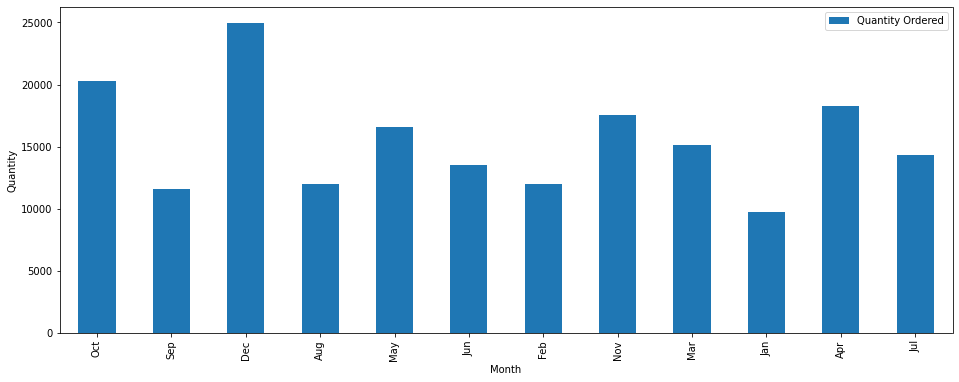

In [31]:
(sales_data_dropna.groupby('month_ordered')
 .agg(
     count(col('Quantity Ordered')).alias('Quantity Ordered')
 ).toPandas().plot(kind='bar', x='month_ordered', xlabel="Month", ylabel='Quantity')
)

In [32]:
sales_data_dropna = sales_data_dropna.withColumn('total_pay', (col('Price Each')*col('Quantity Ordered')))

In [33]:
monthly_highest_sales = sales_data_dropna.groupby('month_ordered').sum('total_pay').alias('monthly_total')

In [34]:
monthly_highest_sales = monthly_highest_sales.withColumnRenamed('sum(total_pay)', 'monthly_total')

In [35]:
monthly_highest_sales.show()

+-------------+------------------+
|month_ordered|     monthly_total|
+-------------+------------------+
|          Oct|3736726.8800009675|
|          Sep| 2097560.129999891|
|          Dec|  4613443.34000153|
|          Aug| 2244467.879999992|
|          May| 3152606.750000546|
|          Jun|2577802.2600001753|
|          Feb| 2202022.419999963|
|          Nov|3199603.2000005865|
|          Mar|2807100.3800003603|
|          Jan|1822256.7299999138|
|          Apr|3390670.2400007015|
|          Jul|2647775.7600002377|
+-------------+------------------+



### Product sold per month

<AxesSubplot:xlabel='Month', ylabel='Sales in USD ($)'>

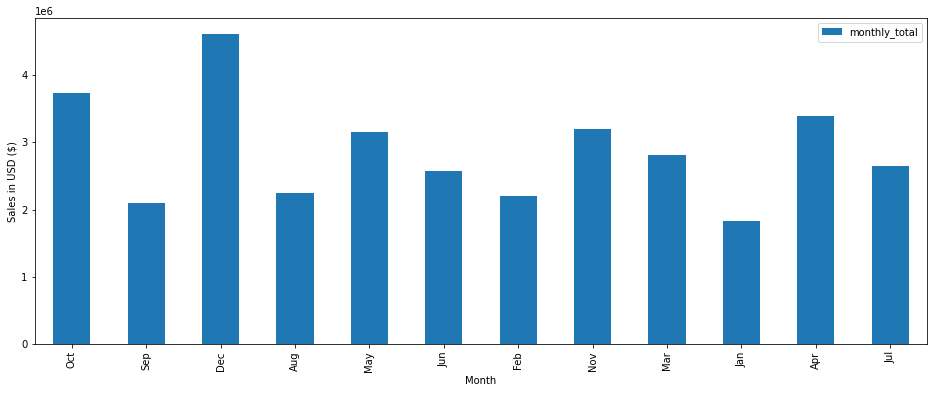

In [36]:
monthly_highest_sales.toPandas().plot(kind='bar', x='month_ordered', xlabel='Month', ylabel='Sales in USD ($)')

### What are the products sold in large amount?

<AxesSubplot:xlabel='Products', ylabel='Quantity Ordered'>

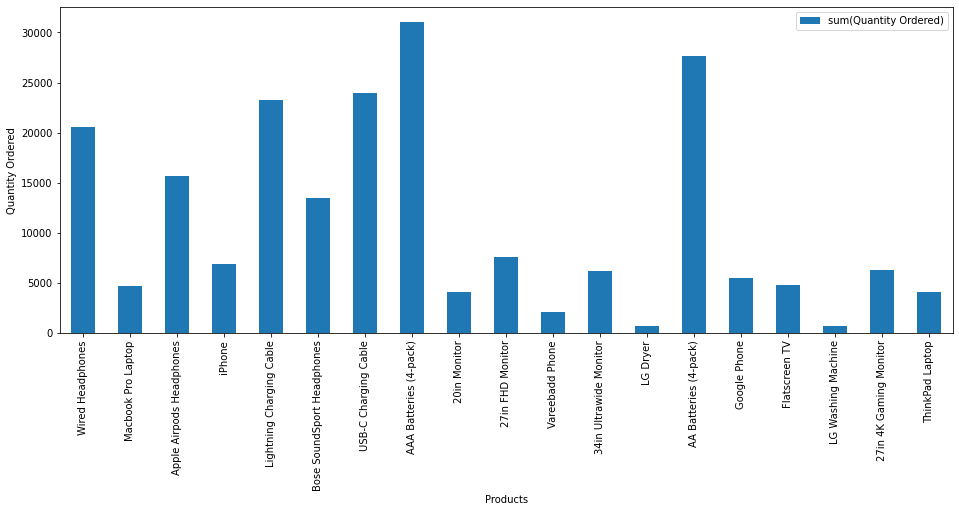

In [37]:
(sales_data_dropna.groupby('Product')
 .agg({'Quantity Ordered': 'sum'})
 .toPandas().plot(kind='bar', x='Product', xlabel='Products', ylabel='Quantity Ordered'))

In [38]:
def clean_addresss(address):
    city = address.split(',')[1].strip()
    state = address.split(',')[2].split(' ')[1].strip()
    return f'{city} ({state})'

clean_addresss_udf = funcs.udf(lambda addrs: clean_addresss(addrs))

In [39]:
sales_data_dropna = sales_data_dropna.withColumn('city', clean_addresss_udf('Purchase Address'))

### Total Sales per city

<AxesSubplot:xlabel='City', ylabel='Sales in USD ($)'>

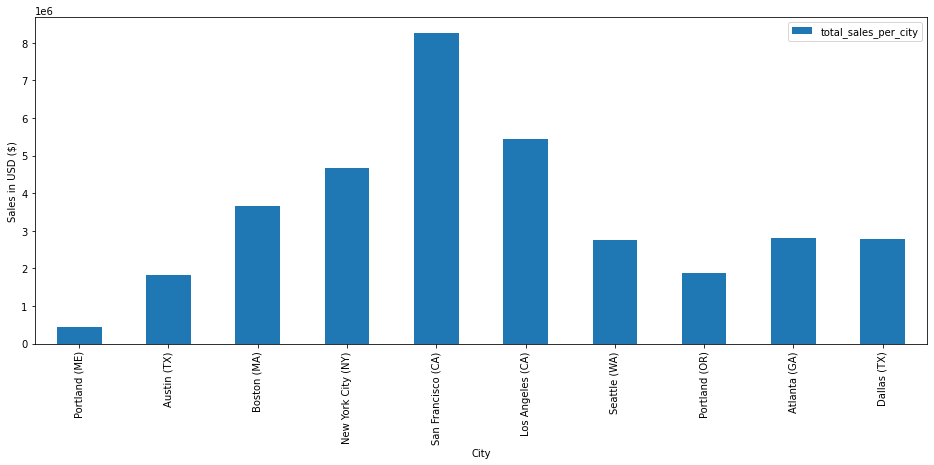

In [40]:
(sales_data_dropna.groupBy('city').sum('total_pay')
 .withColumnRenamed('sum(total_pay)', 'total_sales_per_city')
 .toPandas().plot(kind='bar', x='city', xlabel='City', ylabel='Sales in USD ($)'))

### Max sales during specific hours

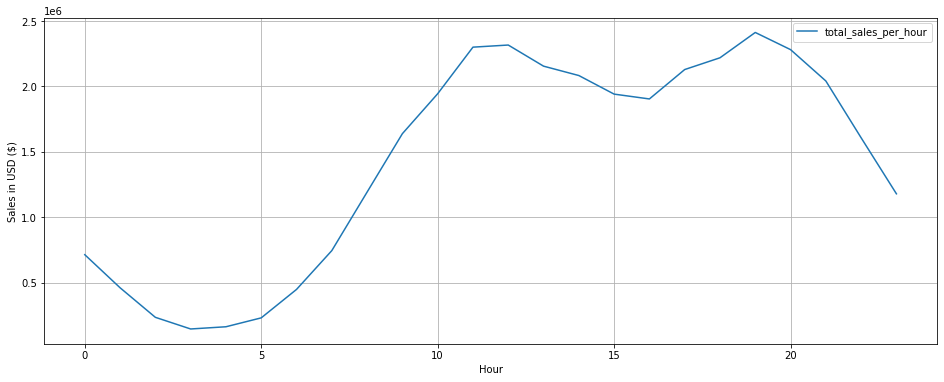

In [41]:
(sales_data_dropna.groupby('hour')
 .sum('total_pay').withColumnRenamed('sum(total_pay)', 'total_sales_per_hour')
 .sort('hour').toPandas().plot(x='hour', xlabel='Hour', ylabel='Sales in USD ($)')
 .grid())

### Find the day of week for entire year which has max product selling.

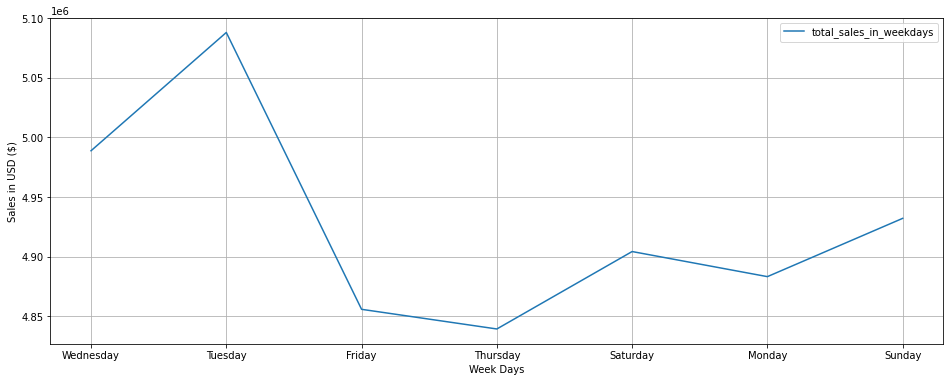

In [42]:
(sales_data_dropna.groupby('full_weekday').sum('total_pay')
 .withColumnRenamed('sum(total_pay)', 'total_sales_in_weekdays')
 .toPandas().plot(x='full_weekday', xlabel='Week Days', ylabel='Sales in USD ($)')
 .grid())

### What are the product sold on `Tuesday`? and How many of each product sold on `Tuesday`?

In [43]:
(sales_data_dropna
 .filter((sales_data_dropna['full_weekday'] == 'Tuesday'))
 .crosstab('full_weekday', 'Product').show())

+--------------------+------------+----------------------+----------------+----------------------+---------------------+----------------------+------------------------+--------------------------+-------------+------------+--------+------------------+------------------------+------------------+---------------+--------------------+---------------+----------------+------+
|full_weekday_Product|20in Monitor|27in 4K Gaming Monitor|27in FHD Monitor|34in Ultrawide Monitor|AA Batteries (4-pack)|AAA Batteries (4-pack)|Apple Airpods Headphones|Bose SoundSport Headphones|Flatscreen TV|Google Phone|LG Dryer|LG Washing Machine|Lightning Charging Cable|Macbook Pro Laptop|ThinkPad Laptop|USB-C Charging Cable|Vareebadd Phone|Wired Headphones|iPhone|
+--------------------+------------+----------------------+----------------+----------------------+---------------------+----------------------+------------------------+--------------------------+-------------+------------+--------+------------------+------

### Check the records which has duplicates Ordered ID's

In [44]:
multiple_item_id_order = sales_data_dropna.groupby('Order ID').count().where(col('count') > 1).sort('count', ascending=False).withColumnRenamed('count', 'total_item_in_order')
multiple_item_id_order.count()

7136

In [45]:
sales_data_dropna_tmp = sales_data_dropna
multiple_item_order_data = multiple_item_id_order.join(sales_data_dropna_tmp, ['Order ID'], 'leftouter')
multiple_item_order_data.count()

14649

### What are the products getting sold togather?

In [46]:
multiple_item_order_data_grouped = (multiple_item_order_data.groupby('Order ID')
 .agg(
     funcs.concat_ws(", ", funcs.collect_list(col('Product'))).alias('items_in_a_order'),
     *[funcs.first(cl).alias(cl) for cl in multiple_item_order_data.columns if not cl == 'Order ID']
 )
)

In [47]:
multiple_item_order_data_grouped.groupby('items_in_a_order').count().sort('count', ascending=False).show(5)

+--------------------+-----+
|    items_in_a_order|count|
+--------------------+-----+
|Lightning Chargin...|  882|
|USB-C Charging Ca...|  856|
|Wired Headphones,...|  361|
|USB-C Charging Ca...|  312|
|Wired Headphones,...|  303|
+--------------------+-----+
only showing top 5 rows

